In [2]:
from utils import *
from os import walk
from adjustText import adjust_text

In [3]:
path = 'activatable promoters/bl/ecoli/v2/'
(_,_,filenames) = list(walk(path))[0]

In [4]:
read_OD = lambda f: pd.read_csv(path+f, delimiter  = '\t', skiprows = 45, index_col = (13,0)).loc['600'].set_index('Unnamed: 0')
OD = {f[:-4] : read_OD(f) for f in filenames if f[-3:] == 'txt'}

read_RFP= lambda f: pd.read_csv(path+f, delimiter  = '\t', skiprows = 45, index_col = (13,0)).loc['RFP:540/35,600/40'].set_index('Unnamed: 0').set_index(OD[f[:-4]].index)
RFP = {f[:-4] : read_RFP(f) for f in filenames if f[-3:] == 'txt'}

In [5]:
plate = pd.read_csv('activatable promoters/bl/ecoli/220204_LAYOUT.csv', index_col = 0, dtype = str) # reads plate layout

# go through the plate layout and identify replicates, make a dictionary of experiments with list of replicate wells
labels = pd.unique(np.concatenate(plate.values))
exps = {}
xlbl = []
for l in labels:
    if type(l) is str:
        xlbl.append(l)
        index = plate[plate.isin([l])].stack().index
        exps[l] = []
        for i in index:
            exps[l].append((i[0], i[1]))
            
lib = [(r,c) for r in RFP['controls_OFF_v2'].index for c in RFP['controls_OFF_v2'].columns]

get_data = lambda X, df, lbl: np.array([df[lbl].loc[x] for x in X])
get_ratio = lambda X, lbl: get_data(X,RFP,lbl)/get_data(X,OD,lbl)

In [6]:
bg = get_ratio(exps['J2'], 'controls_OFF_v2').mean()

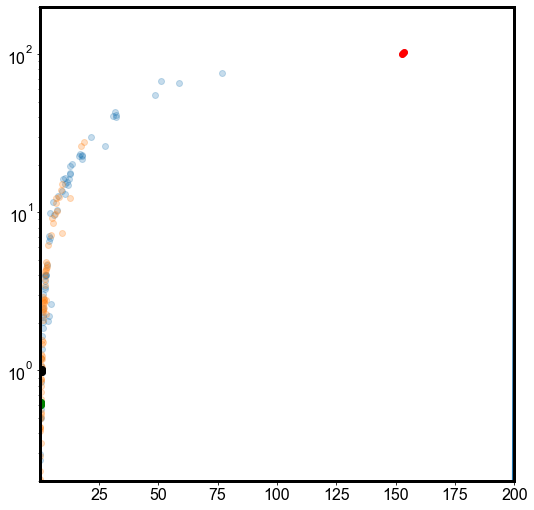

In [7]:
norm_off = (get_ratio(exps['Bllux'], 'controls_OFF_v2')-bg).mean()
norm_on = (get_ratio(exps['Bllux'], 'controls_ON_v2')-bg).mean()
norm_dr = norm_on/norm_off

plt.scatter((get_ratio(lib, 'controls_OFF_v2')-bg)/norm_off,(get_ratio(lib, 'controls_ON_v2')-bg)/norm_on, alpha = 0.25)
plt.scatter((get_ratio(lib, 'pWS025_OFF_v2')-bg)/norm_off,(get_ratio(lib, 'pWS025_ON_v2')-bg)/norm_on, alpha = 0.25)
plt.scatter((get_ratio(exps['119'], 'controls_OFF_v2')-bg)/norm_off,(get_ratio(exps['119'], 'controls_ON_v2')-bg)/norm_on, color = 'r')
#plt.scatter((get_ratio(exps['JN'], 'controls_OFF_v2')-bg)/norm_off,(get_ratio(exps['JN'], 'controls_ON_v2')-bg)/norm_on, color = 'r')
plt.scatter((get_ratio(exps['Bllux'], 'controls_OFF_v2')-bg)/norm_off,(get_ratio(exps['Bllux'], 'controls_ON_v2')-bg)/norm_on, color = 'k')
plt.scatter((get_ratio(exps['BLp8'], 'controls_OFF_v2')-bg)/norm_off,(get_ratio(exps['BLp8'], 'controls_ON_v2')-bg)/norm_on, color = 'g')

plt.plot([0,200],[0,200])
plt.yscale('log')
plt.xlim([0.2,200])
plt.ylim([0.2,200])
plt.gca().set_aspect(1./plt.gca().get_data_ratio())


Text(0.5, 1.0, 'EL222 promoter screen')

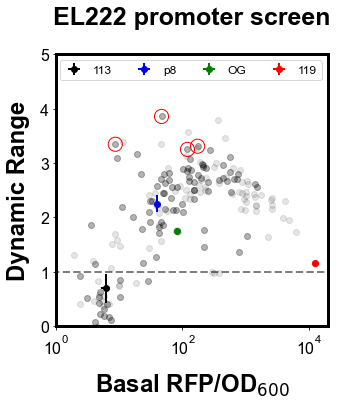

In [8]:
plt.figure(figsize=(5,5))

basal_screen = (get_ratio(lib, 'pWS025_OFF_v2')-bg)
dr_screen = ((get_ratio(lib, 'pWS025_ON_v2')-bg) / (get_ratio(lib, 'pWS025_OFF_v2')-bg))
plt.plot(basal_screen,dr_screen,'ko', alpha = 0.3)
plt.plot((get_ratio(lib, 'controls_OFF_v2')-bg),((get_ratio(lib, 'controls_ON_v2')-bg) / (get_ratio(lib, 'controls_OFF_v2')-bg)),'ko', alpha = 0.1)

for l,c,lbl in zip(['BL113','BLp8','Bllux','119'],['ko','bo','go','ro'],['113','p8','OG','119']):
    basal = (get_ratio(exps[l], 'controls_OFF_v2')-bg)         
    dr = (get_ratio(exps[l], 'controls_ON_v2')-bg) / (get_ratio(exps[l], 'controls_OFF_v2')-bg)
               
    plt.errorbar(basal.mean(), dr.mean(), xerr = basal.std(), yerr = dr.std(),fmt= c, label = lbl)

for v in np.where(*[((get_ratio(lib, 'pWS025_ON_v2')-bg) / (get_ratio(lib, 'pWS025_OFF_v2')-bg)) > 3.24]):
    plt.scatter(basal_screen[v],dr_screen[v], color = 'r', alpha = 1, s = 200,facecolors='none')

    

plt.xscale('log')
plt.plot([0,30000],[1,1],'k--', alpha = 0.5)
plt.ylim([0,5])
plt.xlim([1,20000])
plt.legend(ncol=4, handlelength = 1.5, fontsize = 12)
plt.gca().set_aspect(1./plt.gca().get_data_ratio())
plt.xlabel('Basal RFP/OD$_{600}$', labelpad = xpad, fontsize = 24)
plt.ylabel('Dynamic Range', labelpad = ypad, fontsize = 24)
plt.title('EL222 promoter screen', pad = xpad*2)

In [ ]:
fDR = lambda B,A: (A-b200.mean()) / (B-b0.mean()+b0.std())
fR = lambda B,A: (A-b200.mean()) - (B-b0.mean()+b0.std())
pareto2 = lambda A, B: [~(np.any((A>a) & (B>b))) for a,b in zip(A,B)]

texts = []
best = {}
plt.figure(figsize=(5,5))
for l in ['3N_ON_','9N_ON_','9W_ON_']:
    R = fR(get_ratio(exps['lib'],l+'0'),get_ratio(exps['lib'],l+'200'))
    DR = fDR(get_ratio(exps['lib'],l+'0'),get_ratio(exps['lib'],l+'200'))
    plt.scatter(R, DR)
    best[l[:2]] = pareto2(DR,R)
    plt.scatter(R[best[l[:2]]],DR[best[l[:2]]], color = 'k', alpha = 1, s = 200,facecolors='none')
    for ll, p,k in zip(np.array(exps['lib']),best[l[:2]], range(93)):
        if p:
            texts.append(plt.text(R[k], DR[k], str(ll)))
            #print(l)
            #print(str(ll))
            #print([R[k],DR[k]])
        
plt.scatter(fR(max0,max200), fDR(max0,max200))
plt.scatter(fR(J30,J3200), fDR(J30,J3200))

plt.legend(['DA3-N','DA9-N','DA9-W','119','J3'])
plt.ylabel('Dynamic Range', labelpad = ypad)
plt.xlabel('Range', labelpad = xpad)

#plt.xlim((-50, 25060.76544007391/2))
#plt.ylim((-5, 1985.92886691264357))
adjust_text(texts, force_points = (20,2), arrowprops=dict(arrowstyle='-', color='gray', alpha = 0.5))


In [73]:
(get_ratio(lib, 'pWS025_ON_v2')-bg) / (get_ratio(lib, 'pWS025_OFF_v2')-bg) > 3.2

array([False, False, False, False, False,  True, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False])

In [75]:
(get_ratio(lib, 'pWS025_OFF_v2')-bg)[(get_ratio(lib, 'pWS025_ON_v2')-bg) / (get_ratio(lib, 'pWS025_OFF_v2')-bg) > 3.2]

array([ 46.61738587,   8.65534791, 272.9411117 , 173.55801281,
       119.98948702])

In [87]:
(get_ratio(lib, 'controls_OFF_v2')-bg)[(get_ratio(lib, 'controls_ON_v2')-bg) / (get_ratio(lib, 'controls_OFF_v2')-bg) > 3.33]

array([120.37926966,  11.27683989, 368.06449345, 472.97345658,
        45.07032182])

In [76]:
np.array(lib)[(get_ratio(lib, 'controls_ON_v2')-bg) / (get_ratio(lib, 'controls_OFF_v2')-bg) > 3.33]

array([['A', '4'],
       ['A', '9'],
       ['A', '10'],
       ['A', '11'],
       ['E', '9']], dtype='<U2')

In [175]:
np.array(lib)[(get_ratio(lib, 'pWS025_ON_v2')-bg) / (get_ratio(lib, 'pWS025_OFF_v2')-bg) > 3.24]

array([['A', '6'],
       ['A', '11'],
       ['C', '7'],
       ['D', '7']], dtype='<U2')

In [84]:
1/((get_ratio(exps['119'], 'controls_ON_v2')-bg) / (get_ratio(exps['119'], 'controls_OFF_v2')-bg)).mean() 

0.863865708086612

In [88]:
np.sort([46,8,272,173,119,120,11,368,472,45])

array([  8,  11,  45,  46, 119, 120, 173, 272, 368, 472])

(array([ 5, 10, 23, 30, 42], dtype=int64),)

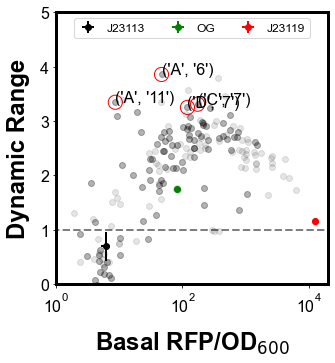

In [25]:
plt.figure(figsize=(5,5))

basal_screen = (get_ratio(lib, 'pWS025_OFF_v2')-bg)
dr_screen = ((get_ratio(lib, 'pWS025_ON_v2')-bg) / (get_ratio(lib, 'pWS025_OFF_v2')-bg))
plt.plot(basal_screen,dr_screen,'ko', alpha = 0.3)
plt.plot((get_ratio(lib, 'controls_OFF_v2')-bg),((get_ratio(lib, 'controls_ON_v2')-bg) / (get_ratio(lib, 'controls_OFF_v2')-bg)),'ko', alpha = 0.1)

for l,c,lbl in zip(['BL113','Bllux','119'],['ko','go','ro'],['J23113','OG','J23119']):
    basal = (get_ratio(exps[l], 'controls_OFF_v2')-bg)         
    dr = (get_ratio(exps[l], 'controls_ON_v2')-bg) / (get_ratio(exps[l], 'controls_OFF_v2')-bg)
               
    plt.errorbar(basal.mean(), dr.mean(), xerr = basal.std(), yerr = dr.std(),fmt= c, label = lbl)

for v in np.where(*[((get_ratio(lib, 'pWS025_ON_v2')-bg) / (get_ratio(lib, 'pWS025_OFF_v2')-bg)) > 3.24])[0]:
    plt.scatter(basal_screen[v],dr_screen[v], color = 'r', alpha = 1, s = 200,facecolors='none')
    plt.text(basal_screen[v], dr_screen[v], s = lib[v])
    

plt.xscale('log')
plt.plot([0,30000],[1,1],'k--', alpha = 0.5)
plt.ylim([0,5])
plt.xlim([1,20000])
plt.legend(ncol=3, handlelength = 1.5, fontsize = 12, loc = 'upper center')
plt.gca().set_aspect(1./plt.gca().get_data_ratio())
plt.xlabel('Basal RFP/OD$_{600}$', labelpad = xpad, fontsize = 24)
plt.ylabel('Dynamic Range', labelpad = ypad, fontsize = 24)

plt.savefig('el222_screen.svg')